# low impact activities
Activities `c310, c320, c340, c370, c410, c430, c440, c510` are expected to have less of an impact on flood losses, based on theoretical considerations. In this notebook, we will test this theoretical intuitions

In [1]:
import os
import numpy as np 
from astropy.table import Table as aT

In [2]:
from noah2 import data as D
from noah2 import util as U

In [3]:
import torch

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [13]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

# read data
read full data set

In [5]:
DNoah = D.Noah2()
fema = DNoah._read_data_full(participants=False)

In [23]:
print(DNoah._columns())
data = np.array([np.array(fema[col]) for col in DNoah._columns()]).T

['amountPaidOnTotalClaim_per_policy', 'mean_rainfall', 'avg_risk_score_all', 'median_household_income', 'population', 'renter_fraction', 'educated_fraction', 'white_fraction', 's_c310', 's_c320', 's_c330', 's_c340', 's_c350', 's_c360', 's_c370', 's_c410', 's_c420', 's_c430', 's_c440', 's_c450', 's_c510', 's_c520', 's_c530', 's_c540', 's_c610', 's_c620', 's_c630']


In [24]:
covars = data[:,1:8].copy()
covars[:,2] = np.log10(covars[:,2])
covars[:,3] = np.log10(covars[:,3])

In [7]:
activities = [] 
for col in fema.colnames: 
    if 's_c' in col and '_avg' not in col:
        activities.append(col[2:])

In [8]:
highimpact_activities = ['c350', 'c360', 'c420', 'c450', 'c520', 'c530', 'c540', 'c610', 'c620', 'c630']

i_highimpact, i_lowimpact = [], []
for i in range(len(activities)): 
    if activities[i] not in highimpact_activities: 
        i_lowimpact.append(i)
    else: 
        i_highimpact.append(i)
i_highimpact = np.array(i_highimpact)
i_lowimpact = np.array(i_lowimpact)

## identify communities that only perform low-impact activities

In [9]:
# codify the activities
scores = np.zeros((len(fema), len(activities)))

for i in range(len(activities)): 
    scores[:,i] = fema[activities[i]]
    
act_codes = np.zeros(len(fema))
for i in range(len(activities)): 
    act_codes += 2**i * (scores[:,i] > 0).astype(int)
    
def uncode(num): 
    act = np.zeros(len(activities)).astype(int)
    while num > 0: 
        ind = int(np.floor(np.log(num)/np.log(2)))
        num = num - 2**ind
        act[ind] = 1
    return act    

In [10]:
only_lowimpact = np.ones(scores.shape[0]).astype(bool)
for i in i_highimpact: 
    only_lowimpact &= (scores[:,i] == 0)
    
only_lowimpact &= ~(np.all(scores == 0, axis=1))
print('%i communities only participate in low-impact activities' % np.sum(only_lowimpact))
print('%i unique zipcodes only participate in low-impact activities' % len(np.unique(fema['zipcode'][only_lowimpact])))

492 communities only participate in low-impact activities
35 unique zipcodes only participate in low-impact activities


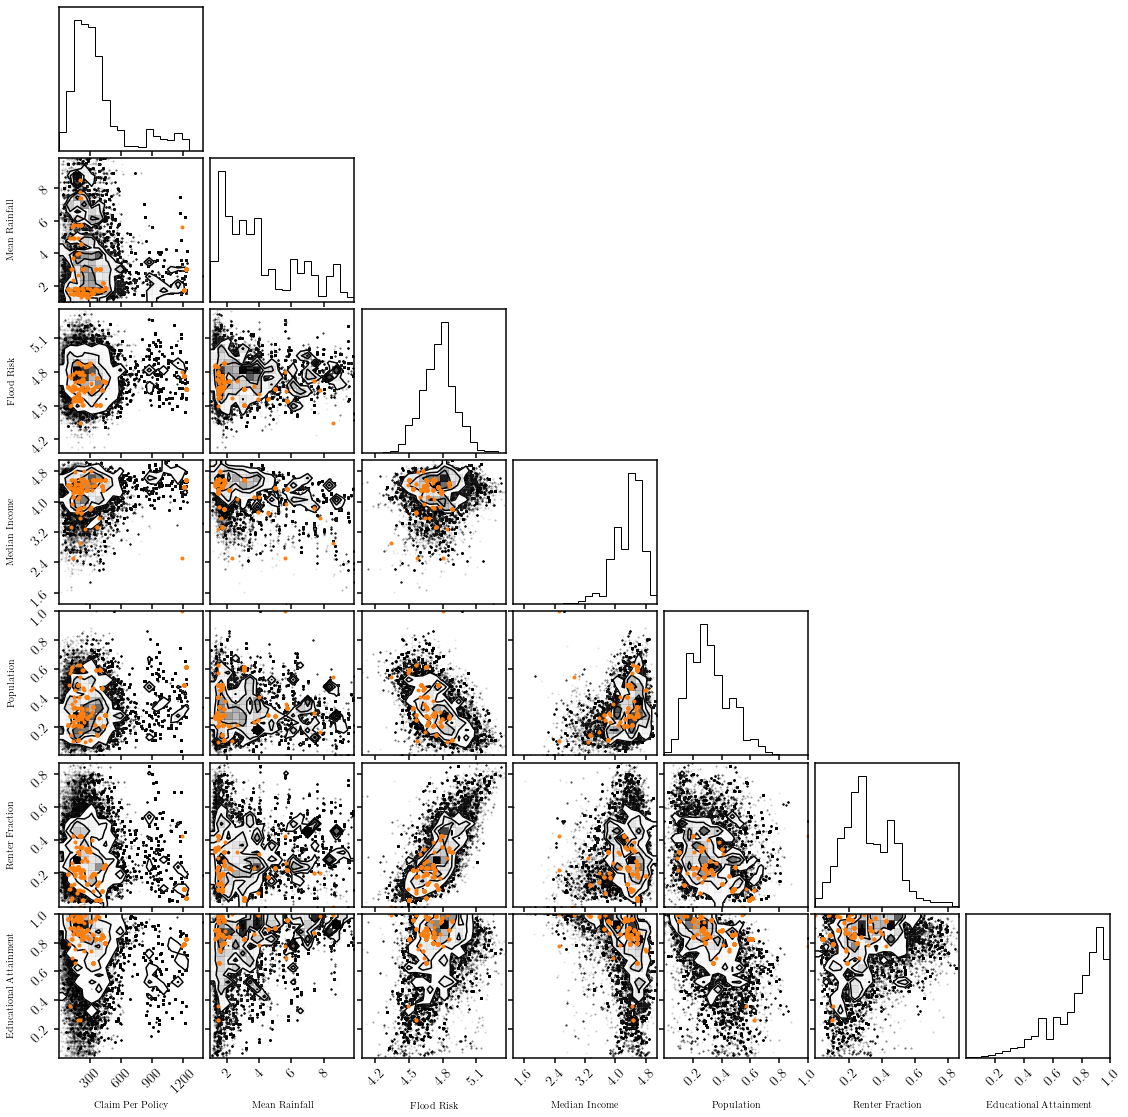

In [25]:
fig = DFM.corner(covars, labels=DNoah._column_labels()[:8])
DFM.overplot_points(fig, covars[only_lowimpact], color='C1')

these communities perform some combination of low-impact CRS activities

In [12]:
for code in np.unique(act_codes[only_lowimpact]): 
    print('%i communities participate in ' % np.sum(act_codes == code), np.array(activities)[uncode(code).astype(bool)])

375 communities participate in  ['c310']
23 communities participate in  ['c310' 'c410' 'c440']
11 communities participate in  ['c310' 'c330' 'c430' 'c440']
9 communities participate in  ['c310' 'c320' 'c330' 'c430' 'c440']
3 communities participate in  ['c310' 'c340' 'c430' 'c440']
25 communities participate in  ['c310' 'c320' 'c330' 'c340' 'c430' 'c440']
8 communities participate in  ['c310' 'c320' 'c330' 'c340' 'c410' 'c430' 'c440']
8 communities participate in  ['c310' 'c320' 'c330' 'c340' 'c440' 'c510']
23 communities participate in  ['c310' 'c330' 'c430' 'c440' 'c510']
7 communities participate in  ['c310' 'c320' 'c330' 'c430' 'c440' 'c510']


# check support

In [14]:
def load_Qphi_support(): 
    ''' load Qphi(X) for binary activity combination
    '''
    Qphi = torch.load('../dat/qphi/noah2.Qphi_support.nonparticipant.prelim.pt', map_location=device)
    return Qphi

def check_support(X, nsample=10000, threshold=0.95, verbose=False): 
    ''' check support for covariates X
    '''
    X = np.atleast_2d(X).copy()
    # preprocess X
    X[:,0] = U.inv_cdf_transform(X[:,0], [-1e-3, 1500])
    X[:,1] = U.inv_cdf_transform(X[:,1], [-1e-3, 10])
    X[:,2] = U.inv_cdf_transform(X[:,2], [3, 6])        
    X[:,3] = U.inv_cdf_transform(X[:,3], [1, 6])        
    X[:,4] = U.inv_cdf_transform(X[:,4], [-1e-3, 1+1e-3])            
    X[:,5] = U.inv_cdf_transform(X[:,5], [-1e-3, 1+1e-3])            
    X[:,6] = U.inv_cdf_transform(X[:,6], [-1e-3, 1+1e-3])      
    
    # load Qphi 
    Qphi = load_Qphi_support()
    Qphi.to(device)
    
    # check support
    with torch.no_grad(): 
        logpX = np.array(Qphi.log_prob(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu())
        if verbose: print(logpX)
            
        _, logps = Qphi.sample_and_log_prob(nsample)
        logps = np.array(logps.detach().cpu())
    
    support = np.zeros(X.shape[0])
    for i in range(X.shape[0]): 
        support[i] = np.mean(logpX[i] < logps)
    if verbose: print(support)
        
    return (support < threshold)

In [93]:
in_support = np.zeros(covars.shape[0]).astype(bool)
in_support[only_lowimpact] = check_support(covars[only_lowimpact], threshold=0.95)
print(np.sum(in_support))

178


# estimate impact on flood claim/policy


$${\rm treatment~effect} = Y_{\rm low~impact}(X) - <Y_{\rm no~activities}(X)>$$
$${\rm treatment~effect} = Y_{\rm low~impact}(X) - <q_\phi^{\rm no~act.}(Y\,|\,X)>$$

$(Y_{\rm low~impact}, X_{\rm low~impact})$ are communities that participate in **any** combination of low-impact CRS activities. Meanwhile $q_\phi^{\rm no~act.}(Y\,|\,X)$ is the distribution of outcome for communities that score all 0s on all CRS activities. 

First lets remove any $(Y_{\rm low~impact}, X_{\rm low~impact})$ outside of the no-activities group support.

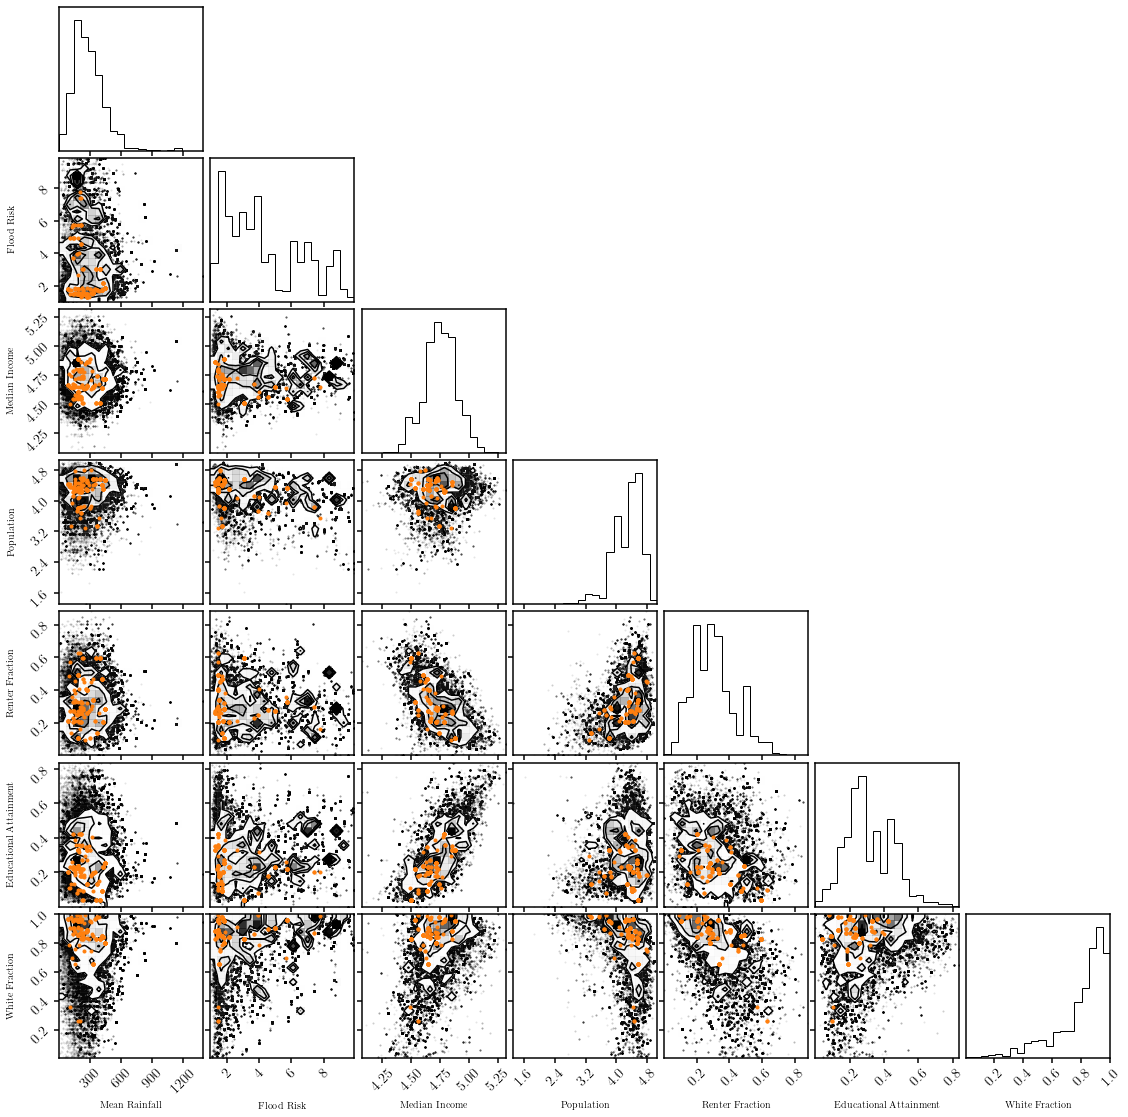

In [94]:
fig = DFM.corner(covars[(act_codes == 0)], labels=DNoah._column_labels()[1:8])
DFM.overplot_points(fig, covars[in_support], color='C1')

In [95]:
for code in np.unique(act_codes[in_support]): 
    print('%i communities %i zipcodes participate in ' % (np.sum(act_codes[in_support] == code), 
                                                          len(np.unique(fema['zipcode'][in_support & (act_codes == code)]))),
          np.array(activities)[uncode(code).astype(bool)])
print('%i communities %i zipcodes participate in some combo' % (np.sum(in_support), 
                                                                len(np.unique(fema['zipcode'][in_support]))))

63 communities 4 zipcodes participate in  ['c310']
23 communities 4 zipcodes participate in  ['c310' 'c410' 'c440']
10 communities 3 zipcodes participate in  ['c310' 'c330' 'c430' 'c440']
9 communities 1 zipcodes participate in  ['c310' 'c320' 'c330' 'c430' 'c440']
3 communities 1 zipcodes participate in  ['c310' 'c340' 'c430' 'c440']
25 communities 7 zipcodes participate in  ['c310' 'c320' 'c330' 'c340' 'c430' 'c440']
8 communities 1 zipcodes participate in  ['c310' 'c320' 'c330' 'c340' 'c410' 'c430' 'c440']
8 communities 1 zipcodes participate in  ['c310' 'c320' 'c330' 'c340' 'c440' 'c510']
22 communities 10 zipcodes participate in  ['c310' 'c330' 'c430' 'c440' 'c510']
7 communities 2 zipcodes participate in  ['c310' 'c320' 'c330' 'c430' 'c440' 'c510']
178 communities 32 zipcodes participate in some combo


In [36]:
# load qphi
qphi = torch.load('../dat/qphi/noah2.qphi.nonparticipant.prelim.pt', map_location=device)

In [128]:
def avg_qphi_nonparticipant(_X, n_sample=10000): 
    '''given array of covariates X, calculate <q_phi(Y|X_i)> for X_i in X
    '''
    # preprocess covariates for consistency with qphi (reduce dynamic range)
    X = _X.copy()

    mu_Y = []
    for i in np.arange(X.shape[0]): 
        # sample qphi
        _samp = qphi.sample((n_sample,), 
                            x=torch.tensor(X[i], dtype=torch.float32).to(device), 
                            show_progress_bars=False)
        # calculate mean
        mu_Y.append(np.mean(10**_samp.detach().cpu().numpy()))
        
    return np.array(mu_Y)

calculate $<q_\phi^{\rm no~act.}>$ for all communities only participating in low-impact activities: 

$$<q_\phi^{\rm no~act.}(Y\,|\,X_i)>$$

for $X_i \in \{{\rm communities~with~no~CRS~activitiy~scores}\}$


In [129]:
# calculate <q_phi^{no act}> for all communities only participating in low-impact activities
X_noact = covars[in_support]
avgY_qphis = avg_qphi_nonparticipant(X_noact, n_sample=10000)

In [141]:
Y_noact = data[in_support][:,0]

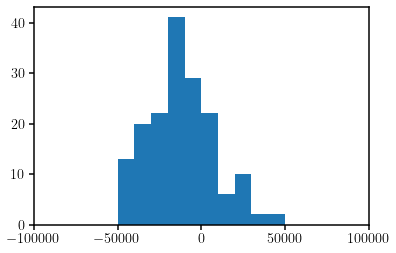

In [143]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
_ = sub.hist((Y_noact - avgY_qphis), range=(-5e4, 5e4), bins=10)
sub.set_xlim(-1e5, 1e5)
plt.show()

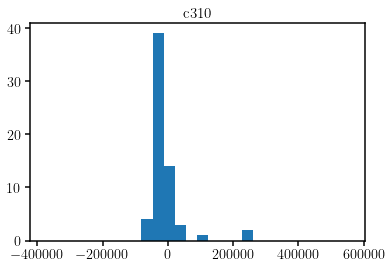

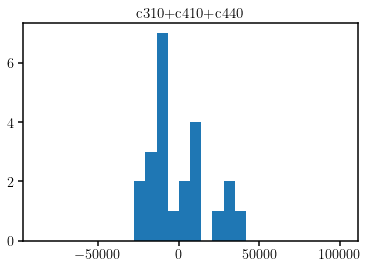

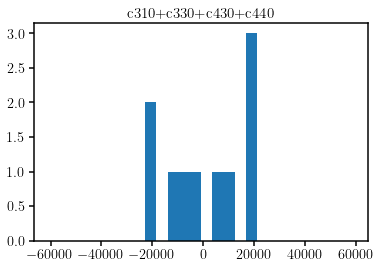

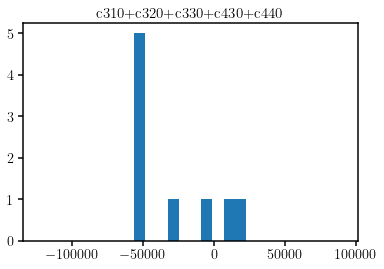

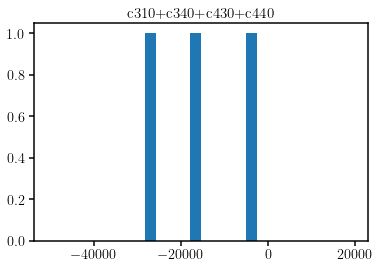

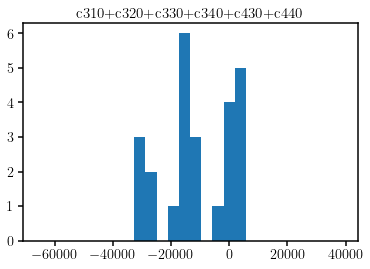

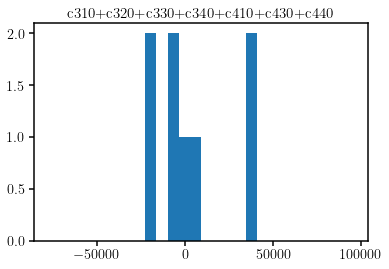

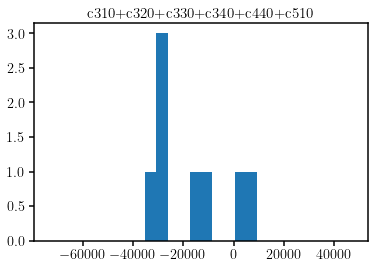

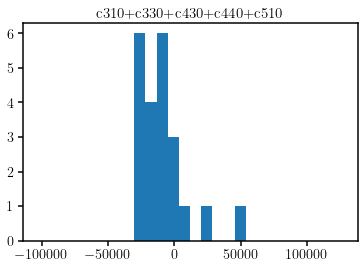

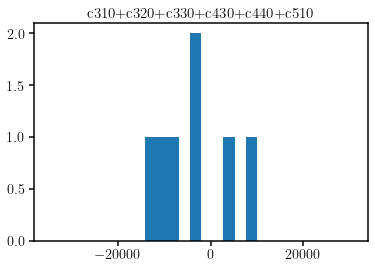

In [144]:
for code in np.unique(act_codes[in_support]): 
    is_code = (act_codes[in_support] == code) 

    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    _ = sub.hist((Y_noact - avgY_qphis)[is_code])
    sub.set_title('+'.join(np.array(activities)[uncode(code).astype(bool)]), fontsize=15)
    plt.show()

(-1.0, 6.0)

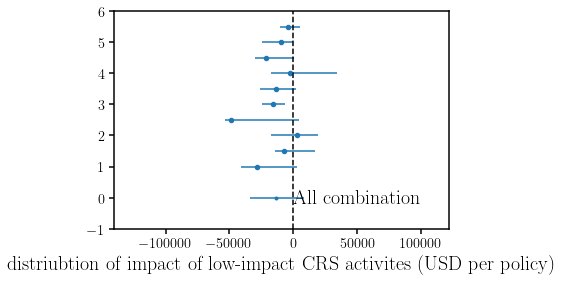

In [150]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

# all combinations
q0, q1, q2 = np.quantile(Y_noact - avgY_qphis, [0.16, 0.5, 0.84])
sub.errorbar([q1], [0], xerr=[[q1-q0], [q2-q1]], fmt='.C0')
sub.text(100000., 0., 'All combination', ha='right', va='center', fontsize=20)

for i, code in enumerate(np.unique(act_codes[in_support])): 
    is_code = (act_codes[in_support] == code) 
    
    q0, q1, q2 = np.quantile((Y_noact - avgY_qphis)[is_code], [0.16, 0.5, 0.84])
    sub.errorbar([q1], [1+0.5*i], xerr=[[q1-q0], [q2-q1]], fmt='.C0')
    sub.scatter([q1], [1+0.5*i], c='C0', s=20)

sub.plot([0., 0.], [-1., 10], c='k', linestyle='--')

sub.set_xlabel('distriubtion of impact of low-impact CRS activites (USD per policy)', fontsize=20)
sub.set_ylim(-1, 6)

## estimate uncertainties using jackknife

In [151]:
def uncertainties_jackknife(Y, func, jackknife): 
    ''' uncertainties from jackknife resampling 
    '''
    n_jk = len(np.unique(jackknife))
    if n_jk < 2: return np.inf
        
    mu_Y = func(Y)
    
    mu_Y_jk = []
    for jk in np.unique(jackknife): 
        is_jack = (jackknife == jk)
        mu_Y_jk.append(func(Y[~is_jack]))
    mu_Y_jk = np.array(mu_Y_jk)
    
    sig_jk = np.sqrt((n_jk - 1)/n_jk * np.sum((mu_Y_jk - mu_Y)**2))
    
    return sig_jk

In [152]:
print(np.mean(Y_noact - avgY_qphis))
for njack in [5, 10, 20, 30, 100]: 
    jackknife = fema['zipcode'][in_support] % njack
    print(uncertainties_jackknife(Y_noact - avgY_qphis, np.mean, jackknife))

-9489.496719455381
4735.227206277027
4383.6519263011705
3500.587050471322
3650.963881139024
3935.4844355665286


In [153]:
print(np.median(Y_noact - avgY_qphis))
for njack in [5, 10, 20, 30, 100]: 
    jackknife = fema['zipcode'][in_support] % njack
    print(uncertainties_jackknife(Y_noact - avgY_qphis, np.median, jackknife))

-13394.4791796875
2389.7089906413635
2656.988542469478
3372.91437512778
3268.1717451868462
3737.3370712393535


1, 63, 4  unique zips: -12615.72, 11934.77
1153, 23, 4  unique zips: -334.84, 3693.35
1541, 10, 3  unique zips: 1249.76, 6188.21
1543, 9, 1  unique zips: -29795.59, inf
1545, 3, 1  unique zips: -15566.87, inf
1551, 25, 7  unique zips: -11046.98, 4893.66
1679, 8, 1  unique zips: 4580.01, inf
5135, 8, 1  unique zips: -17327.63, inf
5637, 22, 10  unique zips: -8245.25, 6802.56
5639, 7, 2  unique zips: -3532.05, 5300.84


(-3.5, 5.1)

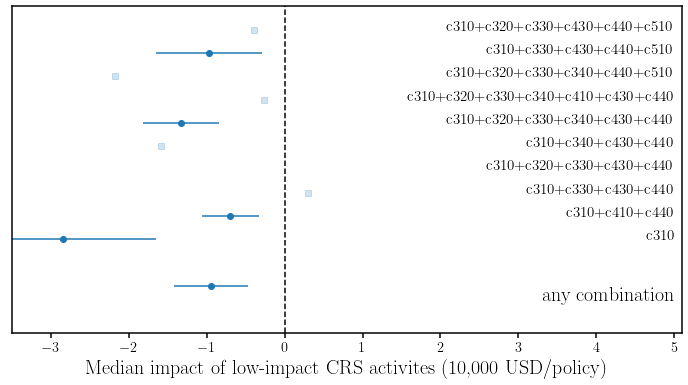

In [157]:
njack = 5

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)

sub.plot([0., 0.], [-1., 10], c='k', linestyle='--')

# all combinations
jackknife = fema['zipcode'][in_support] % njack
sig_jk = uncertainties_jackknife(Y_noact - avgY_qphis, np.mean, jackknife)

sub.errorbar([np.mean(Y_noact - avgY_qphis)/1e4], [0], xerr=[[sig_jk/1e4], [sig_jk/1e4]], fmt='.C0')
sub.scatter([np.mean(Y_noact - avgY_qphis)/1e4], [0], c='C0')
sub.text(5, -0.2, 'any combination', ha='right', va='center', fontsize=20)

for i, code in enumerate(np.unique(act_codes[in_support])): 
    is_code = (act_codes[in_support] == code) 
    sig_jk = uncertainties_jackknife((Y_noact - avgY_qphis)[is_code], np.mean, jackknife[is_code])
    print('%i, %i, %i  unique zips: %.2f, %.2f' % (code, np.sum(is_code), 
                                                   len(np.unique(fema['zipcode'][in_support][is_code])), 
          np.mean((Y_noact - avgY_qphis)[is_code]), sig_jk))
          
    if np.isfinite(sig_jk) and len(np.unique(fema['zipcode'][in_support][is_code])) > 3: 
        sub.errorbar([np.median((Y_noact - avgY_qphis)[is_code])/1e4], [1+0.5*i], 
                     xerr=[[sig_jk/1e4], [sig_jk/1e4]], fmt='.C0')
        sub.scatter([np.median((Y_noact - avgY_qphis)[is_code])/1e4], [1+0.5*i], c='C0', alpha=1)
    else: 
        sub.scatter([np.median((Y_noact - avgY_qphis)[is_code])/1e4], [1+0.5*i], c='C0', alpha=0.2, marker='s')
    sub.text(5, 1+0.5*i, '+'.join(list(np.array(activities)[uncode(code).astype(bool)])), 
             ha='right', va='baseline', fontsize=15)

sub.set_xlabel('Median impact of low-impact CRS activites (10,000 USD/policy)', fontsize=20)
sub.set_ylim(-1, 6)
sub.set_yticks([])
sub.set_xlim(-3.5, 5.1)